# STARSKØPE

## Part III: MAST API via AWS

**STARSKØPE Phase 3 Objectives**

1. Use datasets from the MAST website (via API) to incorporate other calculations of the star's properties as features to be used for classification algorithms. Furthermore, attempt other types of transformations and normalizations on the data before running the model - for instance, apply a Fourier transform.

2. Combine data from multiple campaigns and perhaps even multiple telescopes (for instance, matching sky coordinates and time intervals between K2, Kepler, and TESS for a batch of stars that have overlapping observations - this would be critical for finding transit periods that are longer than the campaigns of a single telecope's observation period).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1MuPehwunnqjGgWI9-k30XKXpOKS59neD#scrollTo=tiR_zPCLZRws)

# Import

In [1]:
# Working with http://astroquery.readthedocs.io/en/latest/mast/mast.html
# Make sure you're running the latest version of the following packages:

# astroquery
# astropy
# boto3
# awscli

In [14]:
#!pip install astroquery

In [16]:
#!pip install astropy

In [18]:
#!pip install -U boto3

In [20]:
#!pip install awscli

In [31]:
import pandas as pd
import numpy as np
import os,glob, sys
import boto3
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astropy.io import fits

# spacekit - my custom python library for astrophysics ML
import spacekit

In [22]:
import matplotlib as mpl
%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
 

font_dict={'family':'"Titillium Web", monospace','size':16}
mpl.rc('font',**font_dict)


#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')
# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

In [7]:
# # If using Jupyter notebook/local
home = os.path.abspath(os.curdir)
os.listdir(home)

# # If using Google Colabs
# from google.colab import drive
# drive.mount('/gdrive',force_remount=True)

['LICENSE.md',
 '.DS_Store',
 'specs',
 'Nontechnical-capstone.pdf',
 'postman',
 'models',
 '288_planetbleed1600.jpeg',
 'README.md',
 'starskope.ipynb',
 '.gitignore',
 '_config.yml',
 '._README.md',
 'starskope_3.ipynb',
 'starskope_4.ipynb',
 '.ipynb_checkpoints',
 'spacekit',
 '.git',
 'plot.tbl',
 'DATA',
 'outputs',
 'starskope_2.ipynb',
 'specs.zip']

In [8]:
# # Jupyter Notebook
# %mkdir ~/.aws/config

# # Google Colab
# %cd '/gdrive/My Drive/'
# %mkdir config

In [9]:
# # change the <tags> to your aws info

# text = '''
# [default]
# aws_access_key_id = <YOUR_AWS_KEY_ID> 
# aws_secret_access_key = <YOUR_AWS_ACCESS_KEY>
# region = us-east-1
# '''

In [10]:
# # Jupyter
# path = "~/.aws/config"
# with open(path, 'w') as f:
#    f.write(text)
# !cat ~/.aws/config

# # Google Colabs
# path = "/gdrive/My Drive/config/awscli.ini"
# with open(path, 'w') as f:
#    f.write(text)
# !cat /gdrive/My\ Drive/config/awscli.ini

In [11]:
# # Jupyter
!export AWS_SHARED_CREDENTIALS_FILE=~/.aws/config
path = '~/.aws/config'
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path
print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

# # Google Colabs
# !export AWS_SHARED_CREDENTIALS_FILE=/gdrive/My\ Drive/config/awscli.ini
# path = path
# os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path
# print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

~/.aws/config


Kepler observed parts of a 10 by 10 degree patch of sky near the constellation of Cygnus for four years (17, 3-month quarters) starting in 2009. The mission downloaded small sections of the sky at a 30-minute (long cadence) and a 1-minute (short cadence) in order to measure the variability of stars and find planets transiting these stars. These data are now available in the public s3://stpubdata/kepler/public S3 bucket on AWS.


https://mast-labs.stsci.io/

These data are available under the same terms as the public dataset for Hubble and TESS, that is, if you compute against the data from the AWS US-East region, then data access is free.

In [23]:
# s3://stpubdata/kepler/public

region = 'us-east-1'
s3 = boto3.resource('s3', region_name=region)
bucket = s3.Bucket('stpubdata')
location = {'LocationConstraint': region}

Cload data access is enabled using the `enable_cloud_dataset` function, which will cause AWS to become the prefered source for data access until it is disabled (`disable_cloud_dataset`).

When cloud access is enabled, the standard download function `download_products` will preferentially pull files from AWS when they are available. There is also a cloud_only flag, which when set to True will cause all data products not available in the cloud to be skipped.

In [50]:
Observations.enable_cloud_dataset(provider='AWS', profile='default')

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]
INFO: See Request Pricing in https://aws.amazon.com/s3/pricing/ for details [astroquery.mast.cloud]
INFO: If you have not configured boto3, follow the instructions here: https://boto3.readthedocs.io/en/latest/guide/configuration.html [astroquery.mast.cloud]


This script queries MAST for TESS FFI data for a single sector/camera/chip combination and downloads the data from the AWS public dataset rather than from MAST servers.

In [24]:
# Example query (not using here but helpful)
#catalog_data = Catalogs.query_criteria(catalog="Tic",Bmag=[30,50],objType="STAR")
#print(catalog_data)

In [25]:
print(Observations.list_missions())

['BEFS', 'EUVE', 'FUSE', 'GALEX', 'HLA', 'HLSP', 'HST', 'HUT', 'IUE', 'JWST', 'K2', 'K2FFI', 'Kepler', 'KeplerFFI', 'PS1', 'SPITZER_SHA', 'SWIFT', 'TESS', 'TUES', 'WUPPE']


In [74]:
target = "K2-1"
#Do a cone search and find the K2 long cadence data for target
obs = Observations.query_object(target,radius="0s")
want = (obs['obs_collection'] == "K2") & (obs['t_exptime'] ==1800.0)

In [77]:
#Pick which data you want to retrieve
data_prod = Observations.get_product_list(obs[want])

In [78]:
data_prod

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights
str10,str2,str10,str20,str37,str1,str97,str7,str28,str8,str1,str2,str2,str63,str34,int64,str1,str6
9500379213,K2,timeseries,ktwo246375295-c12_lc,Preview-Full,S,mast:K2/url/missions/k2/previews/c12/246300000/75000/ktwo246375295-c12_llc_bw_large.png,PREVIEW,--,--,--,K2,39,GO12062_GO12071_GO12085_GO12099_GO12122_GO12124_GO12902_GO12903,ktwo246375295-c12_llc_bw_large.png,23279,0,PUBLIC
9500379213,K2,timeseries,ktwo246375295-c12_lc,Lightcurve Long Cadence (KLC) - C12,S,mast:K2/url/missions/k2/lightcurves/c12/246300000/75000/ktwo246375295-c12_llc.fits,SCIENCE,Minimum Recommended Products,LLC,--,K2,39,GO12062_GO12071_GO12085_GO12099_GO12122_GO12124_GO12902_GO12903,ktwo246375295-c12_llc.fits,417600,0,PUBLIC
9500379213,K2,timeseries,ktwo246375295-c12_lc,Target Pixel Long Cadence (KTL) - C12,S,mast:K2/url/missions/k2/target_pixel_files/c12/246300000/75000/ktwo246375295-c12_lpd-targ.fits.gz,SCIENCE,Minimum Recommended Products,LPD-TARG,--,K2,39,GO12062_GO12071_GO12085_GO12099_GO12122_GO12124_GO12902_GO12903,ktwo246375295-c12_lpd-targ.fits.gz,6905351,0,PUBLIC


In [80]:
filt_prod = Observations.filter_products(data_prod, productSubGroupDescription="LLC")

filt_prod

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights
str10,str2,str10,str20,str37,str1,str97,str7,str28,str8,str1,str2,str2,str63,str34,int64,str1,str6
9500379213,K2,timeseries,ktwo246375295-c12_lc,Lightcurve Long Cadence (KLC) - C12,S,mast:K2/url/missions/k2/lightcurves/c12/246300000/75000/ktwo246375295-c12_llc.fits,SCIENCE,Minimum Recommended Products,LLC,--,K2,39,GO12062_GO12071_GO12085_GO12099_GO12122_GO12124_GO12902_GO12903,ktwo246375295-c12_llc.fits,417600,0,PUBLIC


In [42]:
# create dir for MAST data
DATA = os.path.abspath(home+'/DATA')
#%mkdir './data/mast'
MAST = os.path.abspath(DATA+'/mast')
MAST

'/Users/hakkeray/Sites/CODE/DATASCIENCE/BOOTCAMP/PROJECTS/starskope/DATA/mast'

In [28]:
# Targets with confirmed exoplanets for K2 mission  
K2_confirmed_planets = ['K2-1','K2-21','K2-28','K2-39','K2-54','K2-55','K2-57','K2-58',
                        'K2-59','K2-60','K2-61','K2-62','K2-63','K2-64','K2-65','K2-66', 
                        'K2-68','K2-70','K2-71','K2-72','K2-73','K2-74','K2-75','K2-76',
                        'K2-116','K2-167','K2-168','K2-169','K2-170','K2-171','K2-172']

In [29]:
len(K2_confirmed_planets)

31

# Download from AWS

In [46]:
%cd DATA/mast

/Users/hakkeray/Sites/CODE/DATASCIENCE/BOOTCAMP/PROJECTS/starskope/DATA/mast


In [33]:
## from spacekit.radio import mast_aws
## function for downloading data from MAST s3 bucket on AWS
def mast_aws(target_list):
    import boto3
    from astroquery.mast import Observations
    from astroquery.mast import Catalogs
    # configure aws settings
    region = 'us-east-1'
    s3 = boto3.resource('s3', region_name=region)
    bucket = s3.Bucket('stpubdata')
    location = {'LocationConstraint': region}
    Observations.enable_cloud_dataset(provider='AWS', profile='default')
    
    for target in target_list:
    #Do a cone search and find the K2 long cadence data for target
        obs = Observations.query_object(target,radius="0s")
        want = (obs['obs_collection'] == "K2") & (obs['t_exptime'] ==1800.0)
        data_prod = Observations.get_product_list(obs[want])
        filt_prod = Observations.filter_products(data_prod, productSubGroupDescription="LLC")
        s3_uris = Observations.get_cloud_uris(filt_prod)
        for url in s3_uris:
        # Extract the S3 key from the S3 URL
            fits_s3_key = url.replace("s3://stpubdata/", "")
            root = url.split('/')[-1]
            bucket.download_file(fits_s3_key, root, ExtraArgs={"RequestPayer": "requester"})
    Observations.disable_cloud_dataset()
    return print('Download Complete')

In [110]:
mast_aws(K2_confirmed_planets)

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]
INFO: See Request Pricing in https://aws.amazon.com/s3/pricing/ for details [astroquery.mast.cloud]
INFO: If you have not configured boto3, follow the instructions here: https://boto3.readthedocs.io/en/latest/guide/configuration.html [astroquery.mast.cloud]


Download Complete


In [34]:
os.listdir(MAST)

['ktwo204890128-c02_llc.fits',
 'ktwo228804845-c102_llc.fits',
 'ktwo220709978-c08_llc.fits',
 'ktwo201227197-c102_llc.fits',
 'ktwo206181769-c03_llc.fits',
 'ktwo228748826-c102_llc.fits',
 'ktwo211924657-c18_llc.fits',
 'ktwo211919004-c18_llc.fits',
 'ktwo211770795-c05_llc.fits',
 'ktwo246067459-c12_llc.fits',
 'ktwo211964830-c16_llc.fits',
 'ktwo246471491-c19_llc.fits',
 'ktwo211529065-c16_llc.fits',
 'ktwo212735333-c17_llc.fits',
 'ktwo228760097-c102_llc.fits',
 'ktwo204129699-c02_llc.fits',
 'ktwo211491383-c16_llc.fits',
 'ktwo205117205-c02_llc.fits',
 'ktwo211816003-c05_llc.fits',
 'ktwo246151543-c12_llc.fits',
 'ktwo247267267-c13_llc.fits',
 'ktwo211916756-c18_llc.fits',
 'ktwo211418729-c18_llc.fits',
 'ktwo228748383-c102_llc.fits',
 'ktwo211791178-c18_llc.fits',
 'ktwo206026136-c03_llc.fits',
 'ktwo214787262-c07_llc.fits',
 'ktwo206162305-c03_llc.fits',
 'ktwo201367065-c01_llc.fits',
 'ktwo203776696-c02_llc.fits',
 'ktwo211525389-c18_llc.fits',
 'ktwo212157262-c05_llc.fits',
 'k

# Nasa Exoplanet Archive API

In [ ]:
# https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag=1

In [144]:
import requests

# Getting response from request
#resp = requests.get('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets')
resp = requests.get('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&select=pl_hostname,ra,dec&where=pl_hostname like K2&format=json')
type(resp)

requests.models.Response

In [145]:
requests.codes.ok

200

In [146]:
print('Response Code:', resp.status_code)
print('Is it OK?', resp.status_code == requests.codes.ok)

Response Code: 200
Is it OK? True


In [205]:

# Note we can only do this becasue r.text() is in JSON format
#r=requests.get('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&select=pl_hostname,ra,dec&where=pl_facility%like%K2')

r=requests.get("https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&format=json&select=pl_hostname&where=pl_hostname like '%K2%'")
results = r.json()

In [206]:
# Don't show your IP
results[0]

{'pl_hostname': 'K2-3'}

In [218]:
print(r.url)
display(results[0])

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&format=json&select=pl_hostname&where=pl_hostname%20like%20'%25K2%25'


{'pl_hostname': 'K2-3'}

In [257]:
targets_df = pd.DataFrame.from_dict(results)

k2_confirmed_total = list(targets_df['pl_hostname'].unique())

In [259]:
k2_targets = []

for a in K2_confirmed_planets:
    for b in k2_confirmed_total:
        if a == b:
            k2_targets.append(a)
            k2_confirmed_total.remove(b)

In [261]:
for b in k2_confirmed_total:
    k2_targets.append(b)

In [263]:
len(k2_targets)

266

In [270]:
k2_targets.remove('K2-288 B')

In [271]:
k2_targets.append('K2-288')

In [267]:
# Passing parameters

# credentials = {'user_name': ru, 'password': 'password'}
# r = requests.get('', params = credentials)

# Download FITS files from MAST on AWS

In [286]:
# trying first 100
mast_aws(k2_targets[0:100])

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]
INFO: See Request Pricing in https://aws.amazon.com/s3/pricing/ for details [astroquery.mast.cloud]
INFO: If you have not configured boto3, follow the instructions here: https://boto3.readthedocs.io/en/latest/guide/configuration.html [astroquery.mast.cloud]


Download Complete


In [288]:
k2_targets.remove('K2-315')

In [289]:
# retrieve the remaining 166
mast_aws(k2_targets[100:])

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]
INFO: See Request Pricing in https://aws.amazon.com/s3/pricing/ for details [astroquery.mast.cloud]
INFO: If you have not configured boto3, follow the instructions here: https://boto3.readthedocs.io/en/latest/guide/configuration.html [astroquery.mast.cloud]


Download Complete


# FITS Light Curves

In [35]:
len(os.listdir(MAST))

348

In [65]:
os.listdir(MAST)[2]

'ktwo220709978-c08_llc.fits'

In [66]:
#fits_file = 'ktwo204890128-c02_llc.fits'
fits_file = 'ktwo220709978-c08_llc.fits'
# hdul = fits.open(fits_image_filename)
# hdul.info()

with fits.open(fits_file) as hdul:
    hdul.info()

Filename: ktwo220709978-c08_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3853R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (14, 17)   int32   


In [67]:
hdul[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; uni

In [68]:
from astropy.timeseries import TimeSeries
ts = TimeSeries.read(fits_file, format='kepler.fits') 

In [69]:
ts

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2016-01-04T13:38:54.934,5.410247e-03,119907,2.3606002e+06,4.3809723e+01,3.4626473e+04,1.4316656e+01,nan,nan,10000000000000000000,nan,nan,nan,nan,177.32088,2.7605094e-05,626.04854,4.0197068e-05,4.2486817e-01,-4.1044626e-02
2016-01-04T14:08:20.291,5.409024e-03,119908,2.3614110e+06,4.3767784e+01,3.4651418e+04,1.4192269e+01,2.3590375e+06,4.3439220e+01,0,nan,nan,nan,nan,177.23795,2.7668191e-05,625.98416,4.0034243e-05,3.3385360e-01,-9.9099487e-02
2016-01-04T14:37:45.649,5.407802e-03,119909,2.3628700e+06,4.3795677e+01,3.4640953e+04,1.4266400e+01,2.3604588e+06,4.3498772e+01,0,nan,nan,nan,nan,177.15555,2.7762846e-05,625.90205,3.9620056e-05,2.3359062e-01,-1.4960502e-01
2016-01-04T15:07:11.006,5.406579e-03,119910,2.3636088e+06,4.3795174e+01,3.4631508e+04,1.4284342e+01,2.3609498e+06,4.3506313e+01,0,nan,nan,nan,nan,177.07082,2.7888716e-05,625.80602,3.8830280e-05,1.3440025e-01,-2.0864224e-01
2016-01-04T15:36:36.364,5.405354e-03,119911,2.3638992e+06,4.3798229e+01,3.4618805e+04,1.4331539e+01,2.3607782e+06,4.3516930e+01,0,nan,nan,nan,nan,176.98870,2.8029715e-05,625.71098,3.7838123e-05,3.6891773e-02,-2.6592341e-01
2016-01-04T16:06:01.721,5.404130e-03,119912,2.3643890e+06,4.3780903e+01,3.4661141e+04,1.4331285e+01,2.3608390e+06,4.3483044e+01,0,nan,nan,nan,nan,176.90464,2.8181114e-05,625.61454,3.7026821e-05,-4.5449629e-02,-3.2478178e-01
2016-01-04T16:35:27.078,5.402905e-03,119913,2.3652132e+06,4.3774738e+01,3.4634969e+04,1.4316993e+01,2.3613215e+06,4.3473339e+01,0,nan,nan,nan,nan,176.81750,2.8316617e-05,625.54129,3.6867412e-05,-1.2813345e-01,-3.8050708e-01
2016-01-04T17:04:52.444,5.401679e-03,119914,2.3647678e+06,4.3802055e+01,3.4697508e+04,1.4442789e+01,2.3608212e+06,4.3493912e+01,0,nan,nan,nan,nan,176.73104,2.8463517e-05,625.47588,3.6852147e-05,-2.1352683e-01,-4.4009349e-01


In [70]:
ts['time', 'pdcsap_flux']

time,pdcsap_flux
,electron / s
object,float32
2016-01-04T13:38:54.934,nan
2016-01-04T14:08:20.291,2.3590375e+06
2016-01-04T14:37:45.649,2.3604588e+06
2016-01-04T15:07:11.006,2.3609498e+06
2016-01-04T15:36:36.364,2.3607782e+06
2016-01-04T16:06:01.721,2.3608390e+06
2016-01-04T16:35:27.078,2.3613215e+06
2016-01-04T17:04:52.444,2.3608212e+06


In [83]:
ts.time.mjd 

array([57391.56869137, 57391.58912374, 57391.60955612, ...,
       57470.23091846, 57470.25135029, 57470.27178202])

In [73]:
ts.time.unix

array([1.45191467e+09, 1.45191643e+09, 1.45191820e+09, ...,
       1.45871108e+09, 1.45871285e+09, 1.45871461e+09])

In [74]:
# tdb = Barycentric Dynamical Time scale
ts.time.scale

'tdb'

Text(0, 0.5, 'SAP Flux (e-/s)')

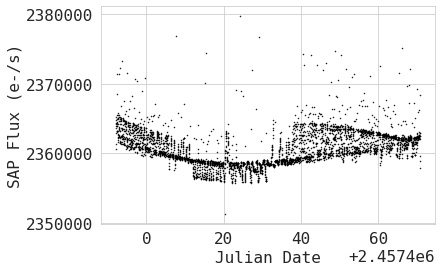

In [111]:
plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

In [112]:
# use box least squares to estimate period
import numpy as np
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')

In [113]:
results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]  
period  

transit_time = results.transit_time[best]  
transit_time  

<Time object: scale='tdb' format='isot' value=2016-01-04T14:50:23.647>

In [114]:
# fold the time series using the period 
ts_folded = ts.fold(period=period, epoch_time=transit_time) 

Text(0, 0.5, 'SAP Flux (e-/s)')

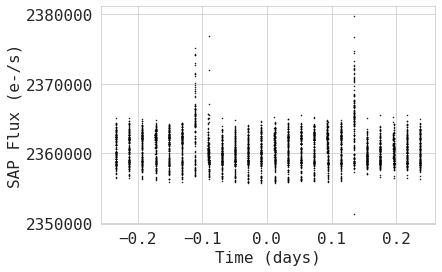

In [115]:
plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

In [116]:
#normalize the flux by sigma-clipping the data to determine the baseline flux:
from astropy.stats import sigma_clipped_stats
mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])  
ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median  

In [117]:
# downsample the time series by binning the points into bins of equal time 
# - this returns a BinnedTimeSeries:
from astropy.timeseries import aggregate_downsample
ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.03 * u.day)  
ts_binned

time_bin_start,time_bin_size,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,sap_flux_norm
,s,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,
object,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-0.2335534174595988,2592.0,0.002055076416581869,121830,2360704.75,43.97222900390625,47985.66796875,14.657724380493164,2360286.75,43.91754150390625,3328,nan,nan,nan,nan,176.8805437560583,2.8902268240926787e-05,625.8580695388282,3.900262527167797e-05,-0.05303758382797241,-0.12111470848321915,1.000117301940918
-0.2035534174595988,2592.0,0.0020522908307611942,121832,2360853.25,43.964698791503906,48010.58203125,14.664273262023926,2360354.75,43.90208053588867,6041,nan,nan,nan,nan,176.8329947254233,2.8984930395381525e-05,625.8243269065226,3.906753772753291e-05,-0.0917993038892746,-0.1501181572675705,1.0001802444458008
-0.1735534174595988,2592.0,0.0020495045464485884,121833,2360910.75,43.95723342895508,48034.5859375,14.676956176757812,2360338.5,43.87224197387695,2150,nan,nan,nan,nan,176.78546625533357,2.907732232415583e-05,625.7906347074692,3.914249828085303e-05,-0.1389220803976059,-0.18524356186389923,1.0002044439315796
-0.1435534174595988,2592.0,0.002046718494966626,121835,2360924.25,43.9458122253418,48057.5546875,14.685757637023926,2360404.0,43.806983947753906,1216,nan,nan,nan,nan,176.7376676512009,2.9176444513723254e-05,625.7586040505665,3.922850009985268e-05,-0.1873505711555481,-0.2213265746831894,1.000210165977478
-0.1135534174595988,2592.0,0.0020439312793314457,121836,2361805.0,43.997100830078125,48136.7265625,14.605667114257812,2360232.0,43.884403228759766,451485,nan,nan,nan,nan,177.09207538336364,2.8698446840280667e-05,626.0377340360211,3.950812970288098e-05,0.1561872661113739,0.02643904834985733,1.0005834102630615
-0.0835534174595988,2592.0,0.002031133510172367,121843,2359853.0,43.97412109375,48162.64453125,14.617408752441406,2360286.25,43.91628646850586,518,nan,nan,nan,nan,177.08536433685063,2.8619460863410495e-05,626.0298275205429,3.936287612305023e-05,0.1470623016357422,0.019314812496304512,0.9997564554214478
-0.053553417459598796,2592.0,0.0020496102515608072,121832,2360005.75,43.970741271972656,48082.5390625,14.617365837097168,2360317.0,43.91610336303711,2202,nan,nan,nan,nan,177.04597907511345,2.8679563911282457e-05,625.9864394791974,3.915267006959766e-05,-0.46254947781562805,-2.012877941131592,0.9998210072517395
-0.023553417459598797,2592.0,0.0020565136801451445,121829,2360210.0,43.970115661621094,48045.09375,14.628466606140137,2360372.75,43.91291427612305,3002,nan,nan,nan,nan,176.99985708700652,2.8753147489624098e-05,625.943167847812,3.8965205021668226e-05,0.06350729614496231,-0.03899052366614342,0.9999076724052429


Text(0, 0.5, 'Normalized flux')

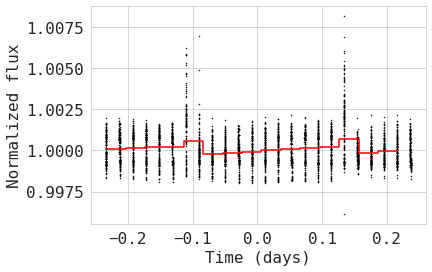

In [118]:
# final result
plt.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
plt.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], 'r-', drawstyle='steps-post')
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')

In [ ]:
files = list(os.listdir(MAST))
targets_df = pd.DataFrame.from_dict(results)

k2_confirmed_total = list(targets_df['pl_hostname'].unique())

In [120]:
files = list(os.listdir(MAST))

In [144]:
file = files[0].replace('ktwo','')
newfile = file.replace('_llc.fits','')
pair = newfile.split('-')

In [145]:
pair

['204890128', 'c02']

In [163]:
def planet_hunter(f=files[0], fmt='kepler.fits'):
    """
    args:
    - fits_files = takes array or single .fits file
    
    kwargs:
    - format : 'kepler.fits' or  'tess.fits'
    """
    from astropy.timeseries import TimeSeries
    import numpy as np
    from astropy import units as u
    from astropy.timeseries import BoxLeastSquares
    from astropy.stats import sigma_clipped_stats
    from astropy.timeseries import aggregate_downsample

    # read in file
    ts = TimeSeries.read(f, format=fmt)
    
#     print(f'mjd: {ts.time.mjd[0]}, {ts.time.mjd [-1]}')
#     # tdb = Barycentric Dynamical Time scale
#     print(f'time_scale: {ts.time.scale}')
#     print(ts['time', 'sap_flux'])
    
    
    # original ts plot
    #fig, ax = plt.figure()
#    plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
    
#     plt.xlabel('Julian Date')
#     plt.ylabel('SAP Flux (e-/s)')
    
    # use box least squares to estimate period
    periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
    results = periodogram.autopower(0.2 * u.day)  
    best = np.argmax(results.power)  
    period = results.period[best]  
    transit_time = results.transit_time[best]  
    print(f'transit_time: {transit_time}')
    
    # fold the time series using the period 
    ts_folded = ts.fold(period=period, epoch_time=transit_time) 
    
#     # folded time series plot
#     plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
#     plt.xlabel('Time (days)')
#     plt.ylabel('SAP Flux (e-/s)')
    
    #normalize the flux by sigma-clipping the data to determine the baseline flux:
    
    mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])  
    ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median  

    # downsample the time series by binning the points into bins of equal time 
    # - this returns a BinnedTimeSeries:
    ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.03 * u.day)  

#     # final result
    fig = plt.figure(figsize=(11,5))
    plt.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
    plt.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], 'r-', drawstyle='steps-post')
    plt.xlabel('Time (days)')
    plt.ylabel('Normalized flux')

transit_time: 2014-08-27T18:51:17.398


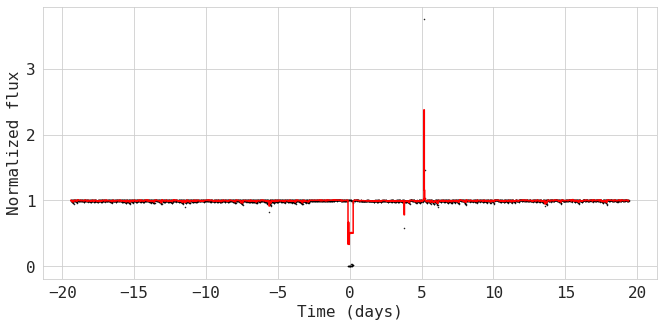

In [164]:
planet_hunter(f=files[0], fmt='kepler.fits')

transit_time: 2016-07-16T11:17:57.175


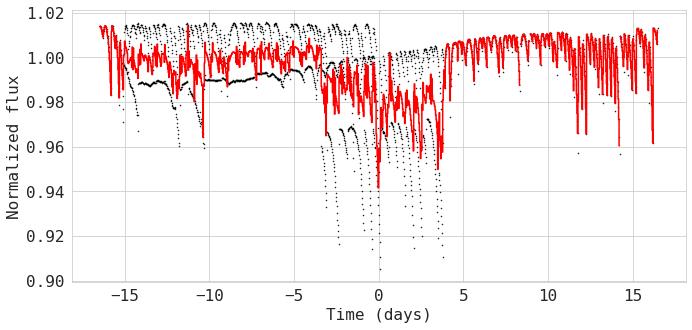

In [165]:
planet_hunter(f=files[1], fmt='kepler.fits')

transit_time: 2016-07-24T08:52:59.446


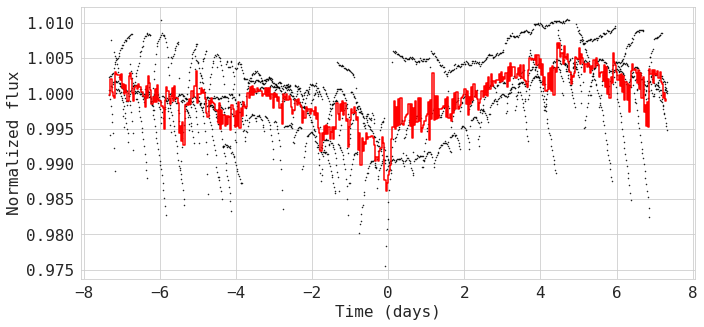

In [166]:
planet_hunter(f=files[3], fmt='kepler.fits')

transit_time: 2014-11-29T05:50:17.962


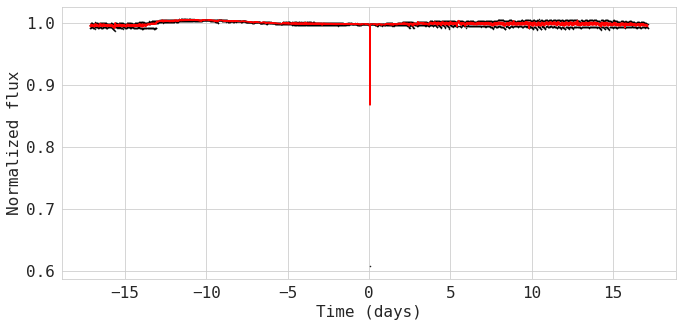

In [167]:
planet_hunter(f=files[4], fmt='kepler.fits')

# FITS image

In [317]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

In [360]:
image_data = fits.getdata('ktwo204890128-c02_llc.fits', ext=2)

In [361]:
print(image_data.shape)

(10, 11)


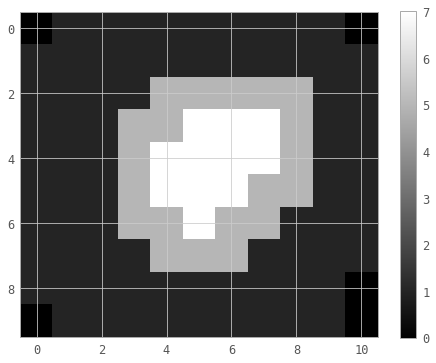

In [362]:
plt.figure()
plt.imshow(image_data, cmap='gray')
plt.colorbar()

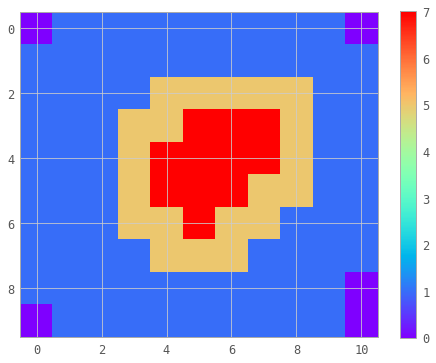

In [369]:
plt.figure()
plt.imshow(image_data, cmap='rainbow')
plt.colorbar()

In [375]:
# !pip install spectral_cube

In [374]:
from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS


In [378]:
# cube = SpectralCube.read('')

# Signal Analysis - CNN Model

In [ ]:
# Estimate period
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
periodogram = BoxLeastSquares.from_timeseries(ts, 'flux')
```

```python
results = periodogram.autopower(0.02 * u.day)
best = np.argmax(results.power)
period = results.period[best]
period
```

# Image Analysis - Keras CNN

In [3]:
import os, glob, sys
from os import path

base_folder = r'specs/'
os.listdir(base_folder)

['test', 'train']

In [4]:
train_base_dir = base_folder+'train/'
test_base_dir = base_folder+'test/'

train_planets_dir = train_base_dir+'planets/'
train_negatives_dir = train_base_dir+'negatives/'

test_planets_dir = test_base_dir+'planets/'
test_negatives_dir = test_base_dir+'negatives/'

In [5]:
planet_train_files = glob.glob(train_planets_dir+'*.png')
negative_train_files = glob.glob(train_negatives_dir+'*.png')
all_train_files = [*planet_train_files, *negative_train_files]

planet_test_files = glob.glob(test_planets_dir+'*.png')
negative_test_files = glob.glob(test_negatives_dir+'*.png')
all_test_files = [*planet_test_files, *negative_test_files]

all_filename_vars = [planet_train_files, negative_train_files,
                     planet_test_files, negative_test_files]

In [6]:
def load_img_cv2(filename, RGB=True):
    import cv2
    IMG = cv2.imread(filename)
    
    if RGB: 
        cmap = cv2.COLOR_BGR2RGB
    
    else:
        cmap=cv2.COLOR_BGR2GRAY
        
    return cv2.cvtColor(IMG, cmap)


In [7]:
from PIL import Image
from keras.preprocessing import image
from imageio import imread
from skimage.transform import resize
from tqdm import tqdm

# defining a function to read images and convert to array
def read_img(img_path, target_size=(8,8)):
    #img = load_img_cv2(img_path)
    #img = image.img_to_array(img)
    img = image.load_img(img_path, target_size=target_size, interpolation='bilinear')
    img = image.img_to_array(img)
    return img

Using TensorFlow backend.


In [8]:
# Read in training and test filenames to produce X and y data splits.

def xy_arrays(planet_train_filenames, negative_train_filenames, 
              planet_test_filenames, negative_test_filenames, 
              img_size=(8,8)):
    # y labels are encoded as 0=negatives, 1=planets
    # returns X_train, X_test, y_train, y_test, y_val
    
    import numpy as np
    
    display('[i] LOADING IMAGES')
    X_img = []
    y_label = []
    
    for img_path in tqdm(planet_train_files):
        X_img.append(read_img(img_path, target_size=img_size))
        y_label.append(1)
        
    for img_path in tqdm(negative_train_files):
        X_img.append(read_img(img_path, target_size=img_size))
        y_label.append(0)
    
    for img_path in tqdm(planet_test_files):
        X_img.append(read_img(img_path, target_size=img_size))
        y_label.append(1)
        
    for img_path in tqdm(negative_test_files):
        X_img.append(read_img(img_path, target_size=img_size))
        y_label.append(0)
        
    from sklearn.model_selection import train_test_split
    X = np.array(X_img, np.float32)
    y = np.array(y_label)
    
    return X, y

In [11]:
X, y = xy_arrays(planet_train_files, negative_train_files, 
              planet_test_files, negative_test_files, 
              img_size=(64,64,3))

'[i] LOADING IMAGES'

100%|██████████| 5/5 [00:00<00:00, 48.90it/s]


In [12]:
X.shape, y.shape

((84, 64, 64, 3), (84,))

In [15]:
X[0][1]

array([[254., 229., 222.],
       [251., 150., 119.],
       [251., 143., 108.],
       [157.,  92.,  74.],
       [ 20.,  20.,  24.],
       [ 22.,  20.,  25.],
       [163.,  73.,  79.],
       [237., 100., 107.],
       [238., 104., 107.],
       [248., 130., 106.],
       [250., 136., 106.],
       [242., 120., 108.],
       [228.,  91., 113.],
       [228.,  90., 113.],
       [220.,  84., 117.],
       [214.,  81., 120.],
       [211.,  80., 121.],
       [184.,  69., 131.],
       [177.,  66., 134.],
       [186.,  70., 130.],
       [218.,  84., 118.],
       [221.,  85., 117.],
       [215.,  82., 120.],
       [208.,  77., 124.],
       [207.,  77., 124.],
       [171.,  64., 133.],
       [153.,  59., 138.],
       [156.,  59., 137.],
       [175.,  66., 134.],
       [178.,  66., 133.],
       [192.,  72., 128.],
       [215.,  81., 120.],
       [214.,  81., 120.],
       [180.,  68., 130.],
       [159.,  60., 137.],
       [166.,  65., 134.],
       [230., 106., 109.],
 

In [159]:
# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [160]:
X, Y = nudge_dataset(X, y)

In [170]:
X.shape

(420, 64, 64, 3)

In [161]:
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [162]:
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

In [163]:
X.shape, y.shape

((420, 64, 64, 3), (84,))

In [ ]:
# X_train,X_test,X_val,y_train,y_test,y_val=load_train_test_val(planet_train_files, 
#                                                               negative_train_files,
#                                                               planet_test_files, 
#                                                               negative_test_files, 
#                                                               val_size=0.1, 
#                                                               img_size=(64,64,3))


#     X_train,X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)
    
#     print('\n[i] Length of Splits:')
#     print(f"X_train={len(X_train)}, X_test={len(X_test)}, X_val={len(X_val)}")
    
#     return X_train, X_test, X_val, y_train, y_test, y_val

In [164]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

In [166]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [167]:
# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

In [169]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [138]:
# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [ ]:
# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

In [ ]:
# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()